Import

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
missing_values = ['8888']

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Dataset/Dataset_Curah_Hujan.xlsx', na_values = missing_values)
df

,Tanggal,RR
0,01-01-2019,NaN
1,02-01-2019,0.0
2,03-01-2019,20.5
3,04-01-2019,2.6
4,05-01-2019,0.9
...,...,...
1699,27-08-2023,0.0
1700,28-08-2023,0.0
1701,29-08-2023,0.0
1702,30-08-2023,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1704 non-null   object 
 1   RR       1426 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.8+ KB


In [6]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

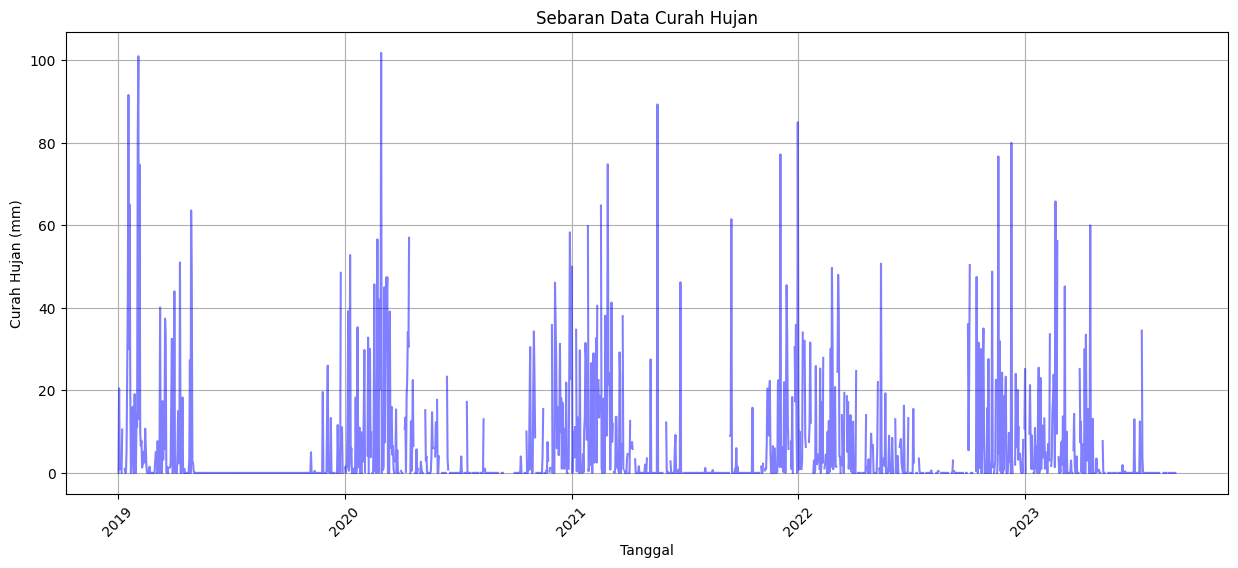

In [7]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
df_1 = df.copy()
df_1

,Tanggal,RR
0,2019-01-01,NaN
1,2019-01-02,0.0
2,2019-01-03,20.5
3,2019-01-04,2.6
4,2019-01-05,0.9
...,...,...
1699,2023-08-27,0.0
1700,2023-08-28,0.0
1701,2023-08-29,0.0
1702,2023-08-30,0.0


In [9]:
df_1.isnull().sum()

Tanggal      0
RR         278
dtype: int64

In [10]:
# Fitur rating yang akan diimputasi
fitur_imputasi = ['RR']

# Daftar nilai parameter yang ingin dicoba
n_neighbors_list = [3, 4, 5]
epoch_list = [12, 25, 50]
learning_rate_list = [0.01, 0.001, 0.0001]
time_step_list = [25, 50, 75]
#split_data_list = [0.5, 0.6, 0.7, 0.8, 0.9]

# Fungsi untuk membangun dan melatih model LSTM
def build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=1)
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return model, rmse

# Membuat folder untuk menyimpan hasil
if not os.path.exists('results'):
    os.makedirs('results')

# Loop melalui kombinasi parameter
results = []
skenario = 1

for n in n_neighbors_list:
    # Imputasi data
    preprocessing = KNNImputer(n_neighbors=n)
    data_imputasi = preprocessing.fit_transform(df[fitur_imputasi])
    data_imputasi_df = pd.DataFrame(data_imputasi, columns=fitur_imputasi)
    df_imputed = df.drop(fitur_imputasi, axis=1).join(data_imputasi_df)

    # Simpan data yang diimputasi
    imputasi_file = f'results/imputasi_n_{n}.csv'
    df_imputed.to_csv(imputasi_file, index=False)

    # Normalisasi data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_imputed[['RR']])
    scaled_data_df = pd.DataFrame(scaled_data)

    # Simpan data yang dinormalisasi
    normalisasi_file = f'results/normalisasi_n_{n}.csv'
    scaled_data_df.to_csv(normalisasi_file, index=False)

    for epochs in epoch_list:
        for learning_rate in learning_rate_list:
            for time_steps in time_step_list:
                # Pembagian data
                values = scaled_data_df.values
                training_data_len = math.ceil(len(values) * 0.7)
                train_data = scaled_data[0:training_data_len, :]

                x_train = []
                y_train = []

                for i in range(time_steps, len(train_data)):
                    x_train.append(train_data[i-time_steps:i, 0])
                    y_train.append(train_data[i, 0])

                x_train, y_train = np.array(x_train), np.array(y_train)
                x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

                test_data = scaled_data[training_data_len-time_steps:, :]
                x_test = []
                y_test = values[training_data_len:]

                for i in range(time_steps, len(test_data)):
                    x_test.append(test_data[i-time_steps:i, 0])

                x_test = np.array(x_test)
                x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

                  # Menyimpan data train dan data testing
                x_train_df = pd.DataFrame({'x_train': x_train.flatten()})
                x_train_file = f'results/xtrain_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                x_train_df.to_csv(x_train_file, index=False)

                y_train_df = pd.DataFrame({'y_train': y_train.flatten()})
                y_train_file = f'results/ytrain_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                y_train_df.to_csv(y_train_file, index=False)

                x_test_df = pd.DataFrame({'x_test': x_test.flatten()})
                x_test_file = f'results/xtest_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                x_test_df.to_csv(x_test_file, index=False)

                y_test_df = pd.DataFrame({'y_test': y_test.flatten()})
                y_test_file = f'results/ytest_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.csv'
                y_test_df.to_csv(y_test_file, index=False)

                # Train and evaluate LSTM model
                model, rmse = build_and_train_lstm(x_train, y_train, x_test, y_test, epochs, learning_rate)

                # Simpan model
                model_file = f'results/model_n_{n}_epochs_{epochs}_lr_{learning_rate}_ts_{time_steps}.h5'
                model.save(model_file)

                # Simpan hasil evaluasi
                results.append([skenario, n, epochs, learning_rate, time_steps, rmse])

                # Print hasil evaluasi
                print(f'Skenario ke-{skenario} : n_neighbors={n}, epochs={epochs}, learning_rate={learning_rate}, time_steps={time_steps}, RMSE={rmse}')
                skenario += 1

# Simpan semua hasil evaluasi ke CSV
results_df = pd.DataFrame(results, columns=['skenario', 'n_neighbors', 'epochs', 'learning_rate', 'time_steps', 'RMSE'])
results_df.to_csv('results/all_results.csv', index=False)

Epoch 1/12
37/37 [==============================] - 7s 56ms/step - loss: 0.0226
Epoch 2/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0141
Epoch 3/12
37/37 [==============================] - 2s 55ms/step - loss: 0.0147
Epoch 4/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 5/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0135
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0140
Epoch 7/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0136
Epoch 8/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0143
Epoch 9/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 10/12
37/37 [==============================] - 2s 55ms/step - loss: 0.0138
Epoch 11/12
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 12/12
16/16 [==============================] - 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-1 : n_neighbors=3, epochs=12, learning_rate=0.01, time_steps=25, RMSE=7.2274387964271165
Epoch 1/12
36/36 [==============================] - 9s 91ms/step - loss: 0.0181
Epoch 2/12
36/36 [==============================] - 3s 72ms/step - loss: 0.0124
Epoch 3/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0132
Epoch 4/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0123
Epoch 5/12
36/36 [==============================] - 4s 106ms/step - loss: 0.0122
Epoch 6/12
36/36 [==============================] - 4s 100ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0123
Epoch 8/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0123
Epoch 9/12
36/36 [==============================] - 3s 72ms/step - loss: 0.0123
Epoch 10/12
36/36 [==============================] - 3s 97ms/step - loss: 0.0124
Epoch 11/12
36/36 [==============================] - 4s 105ms/step - loss: 0.0125
Epoch 12/12
16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-2 : n_neighbors=3, epochs=12, learning_rate=0.01, time_steps=50, RMSE=6.158767527934121
Epoch 1/12
35/35 [==============================] - 10s 142ms/step - loss: 0.0346
Epoch 2/12
35/35 [==============================] - 4s 103ms/step - loss: 0.0126
Epoch 3/12
35/35 [==============================] - 4s 103ms/step - loss: 0.0123
Epoch 4/12
35/35 [==============================] - 5s 143ms/step - loss: 0.0122
Epoch 5/12
35/35 [==============================] - 4s 126ms/step - loss: 0.0125
Epoch 6/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0124
Epoch 7/12
35/35 [==============================] - 4s 103ms/step - loss: 0.0122
Epoch 8/12
35/35 [==============================] - 6s 163ms/step - loss: 0.0122
Epoch 9/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0125
Epoch 10/12
35/35 [==============================] - 5s 150ms/step - loss: 0.0125
Epoch 11/12
35/35 [==============================] - 5s 140ms/step - loss: 0.0121
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-3 : n_neighbors=3, epochs=12, learning_rate=0.01, time_steps=75, RMSE=3.1890162444541756
Epoch 1/12
37/37 [==============================] - 8s 65ms/step - loss: 0.0139
Epoch 2/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 3/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 4/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 5/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 8/12
37/37 [==============================] - 2s 52ms/step - loss: 0.0131
Epoch 9/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0131
Epoch 10/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0132
Epoch 11/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0131
Epoch 12/12
16/16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-4 : n_neighbors=3, epochs=12, learning_rate=0.001, time_steps=25, RMSE=7.796539719928
Epoch 1/12
36/36 [==============================] - 7s 97ms/step - loss: 0.0127
Epoch 2/12
36/36 [==============================] - 4s 105ms/step - loss: 0.0122
Epoch 3/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0122
Epoch 4/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0123
Epoch 5/12
36/36 [==============================] - 3s 72ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 93ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 8/12
36/36 [==============================] - 3s 72ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0119
Epoch 10/12
36/36 [==============================] - 3s 73ms/step - loss: 0.0119
Epoch 11/12
36/36 [==============================] - 3s 83ms/step - loss: 0.0120
Epoch 12/12
16/16 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 7s 102ms/step - loss: 0.0139
Epoch 2/12
35/35 [==============================] - 5s 154ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 4s 104ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 4s 104ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 6s 168ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 4s 104ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 103ms/step - loss: 0.0121
Epoch 9/12
35/35 [==============================] - 4s 120ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 5s 155ms/step - loss: 0.0122
Epoch 11/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0119
Epoch 12/12
16/16 [==============================] - 1s 37ms/step
Skenario ke-6 : n_neighbors=3, epochs=12,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 6s 43ms/step - loss: 0.0139
Epoch 2/12
37/37 [==============================] - 2s 54ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0133
Epoch 4/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0134
Epoch 5/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 8/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 9/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 10/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 11/12
37/37 [==============================] - 2s 61ms/step - loss: 0.0132
Epoch 12/12
16/16 [==============================] - 1s 15ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-7 : n_neighbors=3, epochs=12, learning_rate=0.0001, time_steps=25, RMSE=5.811147861422123
Epoch 1/12
36/36 [==============================] - 6s 74ms/step - loss: 0.0127
Epoch 2/12
36/36 [==============================] - 3s 84ms/step - loss: 0.0121
Epoch 3/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 4/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 5/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 7/12
36/36 [==============================] - 3s 80ms/step - loss: 0.0122
Epoch 8/12
36/36 [==============================] - 4s 117ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 86ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0121
Epoch 11/12
36/36 [==============================] - 3s 74ms/step - loss: 0.0119
Epoch 12/12
16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-8 : n_neighbors=3, epochs=12, learning_rate=0.0001, time_steps=50, RMSE=6.091876256626611
Epoch 1/12
35/35 [==============================] - 8s 105ms/step - loss: 0.0133
Epoch 2/12
35/35 [==============================] - 4s 110ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 6s 165ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 4s 104ms/step - loss: 0.0122
Epoch 5/12
35/35 [==============================] - 4s 104ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 7/12
35/35 [==============================] - 5s 145ms/step - loss: 0.0120
Epoch 8/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0120
Epoch 9/12
35/35 [==============================] - 4s 103ms/step - loss: 0.0120
Epoch 10/12
35/35 [==============================] - 5s 144ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 5s 129ms/step - loss: 0.0120
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 7s 64ms/step - loss: 0.0207
Epoch 2/25
37/37 [==============================] - 2s 40ms/step - loss: 0.0138
Epoch 3/25
37/37 [==============================] - 1s 38ms/step - loss: 0.0141
Epoch 4/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 1s 38ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0140
Epoch 7/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0139
Epoch 8/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 2s 62ms/step - loss: 0.0135
Epoch 10/25
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 2s 49ms/step - loss: 0.0141
Epoch 12/25
37/37 [==============================] - 1s 38ms/step - loss: 0.0137
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 9s 77ms/step - loss: 0.0308
Epoch 2/25
36/36 [==============================] - 3s 95ms/step - loss: 0.0130
Epoch 3/25
36/36 [==============================] - 5s 127ms/step - loss: 0.0128
Epoch 4/25
36/36 [==============================] - 4s 124ms/step - loss: 0.0123
Epoch 5/25
36/36 [==============================] - 3s 84ms/step - loss: 0.0122
Epoch 6/25
36/36 [==============================] - 3s 78ms/step - loss: 0.0127
Epoch 7/25
36/36 [==============================] - 3s 78ms/step - loss: 0.0123
Epoch 8/25
36/36 [==============================] - 3s 90ms/step - loss: 0.0127
Epoch 9/25
36/36 [==============================] - 4s 124ms/step - loss: 0.0124
Epoch 10/25
36/36 [==============================] - 3s 81ms/step - loss: 0.0123
Epoch 11/25
36/36 [==============================] - 3s 78ms/step - loss: 0.0119
Epoch 12/25
36/36 [==============================] - 3s 78ms/step - loss: 0.0124
Epoch 13/25
36/36 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-11 : n_neighbors=3, epochs=25, learning_rate=0.01, time_steps=50, RMSE=5.959267769678429
Epoch 1/25
35/35 [==============================] - 7s 106ms/step - loss: 0.0193
Epoch 2/25
35/35 [==============================] - 5s 140ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0130
Epoch 4/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0124
Epoch 5/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0126
Epoch 6/25
35/35 [==============================] - 6s 162ms/step - loss: 0.0123
Epoch 7/25
35/35 [==============================] - 4s 113ms/step - loss: 0.0122
Epoch 8/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0123
Epoch 9/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0124
Epoch 10/25
35/35 [==============================] - 6s 160ms/step - loss: 0.0123
Epoch 11/25
35/35 [==============================] - 4s 105ms/step - loss: 0.0122
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 7s 58ms/step - loss: 0.0141
Epoch 2/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 3/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 4/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 5/25
37/37 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 2s 60ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0131
Epoch 10/25
37/37 [==============================] - 2s 50ms/step - loss: 0.0132
Epoch 11/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 12/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0131
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-13 : n_neighbors=3, epochs=25, learning_rate=0.001, time_steps=25, RMSE=5.90044802592665
Epoch 1/25
36/36 [==============================] - 7s 75ms/step - loss: 0.0127
Epoch 2/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0123
Epoch 3/25
36/36 [==============================] - 3s 93ms/step - loss: 0.0126
Epoch 4/25
36/36 [==============================] - 4s 114ms/step - loss: 0.0123
Epoch 5/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 6/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 7/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0122
Epoch 8/25
36/36 [==============================] - 4s 99ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 4s 113ms/step - loss: 0.0121
Epoch 10/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0119
Epoch 11/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0119
Epoch 12/25
36/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 111ms/step - loss: 0.0124
Epoch 2/25
35/35 [==============================] - 4s 111ms/step - loss: 0.0124
Epoch 3/25
35/35 [==============================] - 5s 149ms/step - loss: 0.0123
Epoch 4/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0127
Epoch 5/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0122
Epoch 6/25
35/35 [==============================] - 4s 121ms/step - loss: 0.0122
Epoch 7/25
35/35 [==============================] - 6s 162ms/step - loss: 0.0120
Epoch 8/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0120
Epoch 9/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0120
Epoch 10/25
35/35 [==============================] - 5s 158ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 6s 39ms/step - loss: 0.0143
Epoch 2/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 3/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 4/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0134
Epoch 9/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0133
Epoch 12/25
37/37 [==============================] - 2s 47ms/step - loss: 0.0132
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-16 : n_neighbors=3, epochs=25, learning_rate=0.0001, time_steps=25, RMSE=5.9514555318922095
Epoch 1/25
36/36 [==============================] - 7s 75ms/step - loss: 0.0130
Epoch 2/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 3/25
36/36 [==============================] - 4s 98ms/step - loss: 0.0120
Epoch 4/25
36/36 [==============================] - 4s 112ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 96ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0119
Epoch 10/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0119
Epoch 11/25
36/36 [==============================] - 3s 74ms/step - loss: 0.0120
Epoch 12/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 170ms/step - loss: 0.0131
Epoch 2/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 4s 126ms/step - loss: 0.0121
Epoch 5/25
35/35 [==============================] - 5s 143ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 7/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0120
Epoch 8/25
35/35 [==============================] - 5s 159ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 4s 119ms/step - loss: 0.0122
Epoch 10/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 11/25
35/35 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 6s 168ms/step - loss: 0.0120
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-18 : n_neighbors=3, epochs=25, learning_rate=0.0001, time_steps=75, RMSE=6.071654020594256
Epoch 1/50
37/37 [==============================] - 5s 41ms/step - loss: 0.0197
Epoch 2/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0142
Epoch 3/50
37/37 [==============================] - 2s 62ms/step - loss: 0.0141
Epoch 4/50
37/37 [==============================] - 2s 65ms/step - loss: 0.0140
Epoch 5/50
37/37 [==============================] - 2s 49ms/step - loss: 0.0137
Epoch 6/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 7/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0140
Epoch 9/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 10/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 11/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0139
Epoch 12/50
37/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-19 : n_neighbors=3, epochs=50, learning_rate=0.01, time_steps=25, RMSE=5.911362607555811
Epoch 1/50
36/36 [==============================] - 8s 95ms/step - loss: 0.0233
Epoch 2/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0128
Epoch 3/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0124
Epoch 4/50
36/36 [==============================] - 3s 90ms/step - loss: 0.0122
Epoch 5/50
36/36 [==============================] - 5s 125ms/step - loss: 0.0131
Epoch 6/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0126
Epoch 7/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0122
Epoch 8/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 4s 109ms/step - loss: 0.0127
Epoch 10/50
36/36 [==============================] - 4s 112ms/step - loss: 0.0123
Epoch 11/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0119
Epoch 12/50
36

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 8s 108ms/step - loss: 0.0165
Epoch 2/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0136
Epoch 3/50
35/35 [==============================] - 6s 169ms/step - loss: 0.0129
Epoch 4/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0125
Epoch 5/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0128
Epoch 6/50
35/35 [==============================] - 5s 149ms/step - loss: 0.0125
Epoch 7/50
35/35 [==============================] - 7s 195ms/step - loss: 0.0122
Epoch 8/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0123
Epoch 9/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0127
Epoch 10/50
35/35 [==============================] - 5s 143ms/step - loss: 0.0128
Epoch 11/50
35/35 [==============================] - 5s 138ms/step - loss: 0.0123
Epoch 12/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0123
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-21 : n_neighbors=3, epochs=50, learning_rate=0.01, time_steps=75, RMSE=7.062793496907538
Epoch 1/50
37/37 [==============================] - 7s 75ms/step - loss: 0.0142
Epoch 2/50
37/37 [==============================] - 3s 75ms/step - loss: 0.0136
Epoch 3/50
37/37 [==============================] - 2s 62ms/step - loss: 0.0133
Epoch 4/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 5/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 6/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0130
Epoch 9/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 59ms/step - loss: 0.0133
Epoch 11/50
37/37 [==============================] - 2s 64ms/step - loss: 0.0132
Epoch 12/50
37/37

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-22 : n_neighbors=3, epochs=50, learning_rate=0.001, time_steps=25, RMSE=5.606050539993924
Epoch 1/50
36/36 [==============================] - 8s 119ms/step - loss: 0.0130
Epoch 2/50
36/36 [==============================] - 3s 86ms/step - loss: 0.0122
Epoch 3/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0123
Epoch 6/50
36/36 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 7/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0122
Epoch 8/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 10/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 4s 120ms/step - loss: 0.0120
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 8s 119ms/step - loss: 0.0128
Epoch 2/50
35/35 [==============================] - 6s 161ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 4s 106ms/step - loss: 0.0123
Epoch 5/50
35/35 [==============================] - 5s 143ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 5s 135ms/step - loss: 0.0123
Epoch 7/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 8/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 9/50
35/35 [==============================] - 6s 167ms/step - loss: 0.0122
Epoch 10/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 11/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0122
Epoch 12/50
35/35 [==============================] - 5s 133ms/step - loss: 0.0123
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-24 : n_neighbors=3, epochs=50, learning_rate=0.001, time_steps=75, RMSE=4.149134322433863
Epoch 1/50
37/37 [==============================] - 7s 47ms/step - loss: 0.0141
Epoch 2/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0133
Epoch 5/50
37/37 [==============================] - 3s 73ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 2s 60ms/step - loss: 0.0134
Epoch 7/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 46ms/step - loss: 0.0134
Epoch 11/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0132
Epoch 12/50
37/3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-25 : n_neighbors=3, epochs=50, learning_rate=0.0001, time_steps=25, RMSE=6.273320144307322
Epoch 1/50
36/36 [==============================] - 7s 79ms/step - loss: 0.0141
Epoch 2/50
36/36 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 3/50
36/36 [==============================] - 4s 103ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 4s 124ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 3s 93ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 10/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 3s 85ms/step - loss: 0.0120
Epoch 12/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 107ms/step - loss: 0.0133
Epoch 2/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0122
Epoch 3/50
35/35 [==============================] - 5s 140ms/step - loss: 0.0121
Epoch 4/50
35/35 [==============================] - 5s 141ms/step - loss: 0.0120
Epoch 5/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 6/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 6s 166ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0121
Epoch 9/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 10/50
35/35 [==============================] - 4s 124ms/step - loss: 0.0121
Epoch 11/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0121
Epoch 12/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 6s 65ms/step - loss: 0.0178
Epoch 2/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0141
Epoch 3/12
37/37 [==============================] - 2s 51ms/step - loss: 0.0135
Epoch 4/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 5/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0137
Epoch 7/12
37/37 [==============================] - 2s 66ms/step - loss: 0.0136
Epoch 8/12
37/37 [==============================] - 2s 64ms/step - loss: 0.0132
Epoch 9/12
37/37 [==============================] - 3s 74ms/step - loss: 0.0133
Epoch 10/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0135
Epoch 11/12
37/37 [==============================] - 2s 56ms/step - loss: 0.0132
Epoch 12/12
16/16 [==============================] - 1s 16ms/step
Skenario ke-28 : n_neighbors=4, epochs=12, learning_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
36/36 [==============================] - 8s 111ms/step - loss: 0.0229
Epoch 2/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 3/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0127
Epoch 4/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0127
Epoch 5/12
36/36 [==============================] - 3s 96ms/step - loss: 0.0123
Epoch 6/12
36/36 [==============================] - 4s 116ms/step - loss: 0.0122
Epoch 7/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0120
Epoch 8/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 9/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 10/12
36/36 [==============================] - 3s 93ms/step - loss: 0.0129
Epoch 11/12
36/36 [==============================] - 4s 120ms/step - loss: 0.0126
Epoch 12/12
16/16 [==============================] - 1s 30ms/step
Skenario ke-29 : n_neighbors=4, epochs=12, learni

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 9s 152ms/step - loss: 0.0157
Epoch 2/12
35/35 [==============================] - 4s 127ms/step - loss: 0.0132
Epoch 3/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0127
Epoch 4/12
35/35 [==============================] - 4s 108ms/step - loss: 0.0126
Epoch 5/12
35/35 [==============================] - 6s 173ms/step - loss: 0.0125
Epoch 6/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0125
Epoch 7/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0129
Epoch 8/12
35/35 [==============================] - 5s 131ms/step - loss: 0.0132
Epoch 9/12
35/35 [==============================] - 5s 148ms/step - loss: 0.0124
Epoch 10/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0123
Epoch 11/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0123
Epoch 12/12
16/16 [==============================] - 1s 39ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-30 : n_neighbors=4, epochs=12, learning_rate=0.01, time_steps=75, RMSE=4.305304244677113
Epoch 1/12
37/37 [==============================] - 5s 40ms/step - loss: 0.0143
Epoch 2/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0137
Epoch 3/12
37/37 [==============================] - 2s 67ms/step - loss: 0.0136
Epoch 4/12
37/37 [==============================] - 2s 48ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 7/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0131
Epoch 8/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0131
Epoch 9/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0130
Epoch 10/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0131
Epoch 11/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 12/12
16/16

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-31 : n_neighbors=4, epochs=12, learning_rate=0.001, time_steps=25, RMSE=4.898314127854136
Epoch 1/12
36/36 [==============================] - 10s 87ms/step - loss: 0.0127
Epoch 2/12
36/36 [==============================] - 3s 88ms/step - loss: 0.0124
Epoch 3/12
36/36 [==============================] - 3s 86ms/step - loss: 0.0121
Epoch 4/12
36/36 [==============================] - 4s 122ms/step - loss: 0.0119
Epoch 5/12
36/36 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 6/12
36/36 [==============================] - 3s 86ms/step - loss: 0.0122
Epoch 7/12
36/36 [==============================] - 3s 87ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 4s 103ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 5s 127ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 86ms/step - loss: 0.0121
Epoch 11/12
36/36 [==============================] - 3s 87ms/step - loss: 0.0121
Epoch 12/12

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-32 : n_neighbors=4, epochs=12, learning_rate=0.001, time_steps=50, RMSE=5.277348959420023
Epoch 1/12
35/35 [==============================] - 8s 111ms/step - loss: 0.0123
Epoch 2/12
35/35 [==============================] - 5s 148ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 5s 140ms/step - loss: 0.0123
Epoch 4/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0124
Epoch 5/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 6s 174ms/step - loss: 0.0122
Epoch 7/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 110ms/step - loss: 0.0121
Epoch 9/12
35/35 [==============================] - 5s 151ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 5s 136ms/step - loss: 0.0123
Epoch 11/12
35/35 [==============================] - 4s 111ms/step - loss: 0.0120
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-33 : n_neighbors=4, epochs=12, learning_rate=0.001, time_steps=75, RMSE=7.991111907844406
Epoch 1/12
37/37 [==============================] - 7s 40ms/step - loss: 0.0143
Epoch 2/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 64ms/step - loss: 0.0134
Epoch 4/12
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 2s 54ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 8/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 9/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 10/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 11/12
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 12/12
16/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-34 : n_neighbors=4, epochs=12, learning_rate=0.0001, time_steps=25, RMSE=5.288698921368978
Epoch 1/12
36/36 [==============================] - 7s 77ms/step - loss: 0.0128
Epoch 2/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 3/12
36/36 [==============================] - 4s 114ms/step - loss: 0.0121
Epoch 4/12
36/36 [==============================] - 3s 95ms/step - loss: 0.0121
Epoch 5/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 7/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 8/12
36/36 [==============================] - 4s 119ms/step - loss: 0.0119
Epoch 9/12
36/36 [==============================] - 3s 93ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0119
Epoch 11/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 12/12
1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
35/35 [==============================] - 8s 110ms/step - loss: 0.0129
Epoch 2/12
35/35 [==============================] - 6s 169ms/step - loss: 0.0122
Epoch 3/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 5s 132ms/step - loss: 0.0121
Epoch 6/12
35/35 [==============================] - 5s 145ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 9/12
35/35 [==============================] - 5s 156ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 12/12
16/16 [==============================] - 2s 53ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-36 : n_neighbors=4, epochs=12, learning_rate=0.0001, time_steps=75, RMSE=6.669922966683878
Epoch 1/25
37/37 [==============================] - 5s 40ms/step - loss: 0.0205
Epoch 2/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 3/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 4/25
37/37 [==============================] - 2s 40ms/step - loss: 0.0135
Epoch 5/25
37/37 [==============================] - 2s 56ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 67ms/step - loss: 0.0135
Epoch 7/25
37/37 [==============================] - 2s 58ms/step - loss: 0.0137
Epoch 8/25
37/37 [==============================] - 2s 40ms/step - loss: 0.0134
Epoch 9/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 10/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0135
Epoch 11/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 12/25
37/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-37 : n_neighbors=4, epochs=25, learning_rate=0.01, time_steps=25, RMSE=6.653983193038459
Epoch 1/25
36/36 [==============================] - 7s 76ms/step - loss: 0.0172
Epoch 2/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0130
Epoch 3/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0125
Epoch 4/25
36/36 [==============================] - 4s 119ms/step - loss: 0.0126
Epoch 5/25
36/36 [==============================] - 3s 95ms/step - loss: 0.0129
Epoch 6/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0124
Epoch 7/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 8/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0123
Epoch 9/25
36/36 [==============================] - 4s 116ms/step - loss: 0.0121
Epoch 10/25
36/36 [==============================] - 3s 93ms/step - loss: 0.0122
Epoch 11/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0123
Epoch 12/25
36/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 12s 151ms/step - loss: 0.0191
Epoch 2/25
35/35 [==============================] - 5s 131ms/step - loss: 0.0134
Epoch 3/25
35/35 [==============================] - 6s 171ms/step - loss: 0.0123
Epoch 4/25
35/35 [==============================] - 5s 142ms/step - loss: 0.0125
Epoch 5/25
35/35 [==============================] - 5s 130ms/step - loss: 0.0124
Epoch 6/25
35/35 [==============================] - 6s 176ms/step - loss: 0.0123
Epoch 7/25
35/35 [==============================] - 5s 143ms/step - loss: 0.0131
Epoch 8/25
35/35 [==============================] - 5s 130ms/step - loss: 0.0122
Epoch 9/25
35/35 [==============================] - 6s 176ms/step - loss: 0.0123
Epoch 10/25
35/35 [==============================] - 5s 143ms/step - loss: 0.0131
Epoch 11/25
35/35 [==============================] - 5s 132ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 6s 180ms/step - loss: 0.0122
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-39 : n_neighbors=4, epochs=25, learning_rate=0.01, time_steps=75, RMSE=6.789733334667493
Epoch 1/25
37/37 [==============================] - 5s 44ms/step - loss: 0.0145
Epoch 2/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0136
Epoch 3/25
37/37 [==============================] - 3s 71ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 3s 68ms/step - loss: 0.0136
Epoch 5/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0134
Epoch 6/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 7/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 2s 44ms/step - loss: 0.0131
Epoch 10/25
37/37 [==============================] - 2s 48ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 3s 70ms/step - loss: 0.0134
Epoch 12/25
37/37

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-40 : n_neighbors=4, epochs=25, learning_rate=0.001, time_steps=25, RMSE=4.692979882512039
Epoch 1/25
36/36 [==============================] - 8s 78ms/step - loss: 0.0137
Epoch 2/25
36/36 [==============================] - 3s 80ms/step - loss: 0.0120
Epoch 3/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0124
Epoch 4/25
36/36 [==============================] - 4s 105ms/step - loss: 0.0124
Epoch 5/25
36/36 [==============================] - 4s 110ms/step - loss: 0.0121
Epoch 6/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0119
Epoch 9/25
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 4s 97ms/step - loss: 0.0121
Epoch 11/25
36/36 [==============================] - 3s 80ms/step - loss: 0.0120
Epoch 12/25
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 9s 110ms/step - loss: 0.0126
Epoch 2/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0123
Epoch 3/25
35/35 [==============================] - 6s 161ms/step - loss: 0.0125
Epoch 4/25
35/35 [==============================] - 4s 117ms/step - loss: 0.0123
Epoch 5/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0123
Epoch 6/25
35/35 [==============================] - 4s 124ms/step - loss: 0.0124
Epoch 7/25
35/35 [==============================] - 6s 159ms/step - loss: 0.0122
Epoch 8/25
35/35 [==============================] - 4s 110ms/step - loss: 0.0120
Epoch 9/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 5s 148ms/step - loss: 0.0122
Epoch 11/25
35/35 [==============================] - 5s 133ms/step - loss: 0.0122
Epoch 12/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 13/25
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-42 : n_neighbors=4, epochs=25, learning_rate=0.001, time_steps=75, RMSE=8.197639443307203
Epoch 1/25
37/37 [==============================] - 5s 41ms/step - loss: 0.0145
Epoch 2/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0134
Epoch 3/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 4/25
37/37 [==============================] - 3s 69ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 2s 40ms/step - loss: 0.0132
Epoch 9/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 11/25
37/37 [==============================] - 2s 51ms/step - loss: 0.0133
Epoch 12/25
37/3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-43 : n_neighbors=4, epochs=25, learning_rate=0.0001, time_steps=25, RMSE=4.496997187652898
Epoch 1/25
36/36 [==============================] - 8s 120ms/step - loss: 0.0138
Epoch 2/25
36/36 [==============================] - 3s 82ms/step - loss: 0.0122
Epoch 3/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 5/25
36/36 [==============================] - 3s 88ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 7/25
36/36 [==============================] - 3s 78ms/step - loss: 0.0122
Epoch 8/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 90ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 12/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 8s 107ms/step - loss: 0.0128
Epoch 2/25
35/35 [==============================] - 5s 138ms/step - loss: 0.0122
Epoch 3/25
35/35 [==============================] - 5s 143ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0122
Epoch 5/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 6s 160ms/step - loss: 0.0121
Epoch 7/25
35/35 [==============================] - 6s 164ms/step - loss: 0.0120
Epoch 8/25
35/35 [==============================] - 5s 130ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 5s 157ms/step - loss: 0.0120
Epoch 10/25
35/35 [==============================] - 4s 121ms/step - loss: 0.0121
Epoch 11/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 12/25
35/35 [==============================] - 4s 120ms/step - loss: 0.0120
Epoch 13/25
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-45 : n_neighbors=4, epochs=25, learning_rate=0.0001, time_steps=75, RMSE=5.912879276086404
Epoch 1/50
37/37 [==============================] - 7s 53ms/step - loss: 0.0201
Epoch 2/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0143
Epoch 3/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 4/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 5/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 6/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 7/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 8/50
37/37 [==============================] - 2s 58ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 66ms/step - loss: 0.0135
Epoch 10/50
37/37 [==============================] - 2s 61ms/step - loss: 0.0132
Epoch 11/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 12/50
37/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 8s 110ms/step - loss: 0.0219
Epoch 2/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0128
Epoch 3/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0128
Epoch 4/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0126
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 0.0123
Epoch 6/50
36/36 [==============================] - 4s 114ms/step - loss: 0.0121
Epoch 7/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0119
Epoch 8/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0125
Epoch 9/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0122
Epoch 10/50
36/36 [==============================] - 3s 93ms/step - loss: 0.0123
Epoch 11/50
36/36 [==============================] - 4s 120ms/step - loss: 0.0128
Epoch 12/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0125
Epoch 13/50
36/36 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-47 : n_neighbors=4, epochs=50, learning_rate=0.01, time_steps=50, RMSE=7.089009209759046
Epoch 1/50
35/35 [==============================] - 11s 158ms/step - loss: 0.0261
Epoch 2/50
35/35 [==============================] - 6s 165ms/step - loss: 0.0126
Epoch 3/50
35/35 [==============================] - 5s 131ms/step - loss: 0.0123
Epoch 4/50
35/35 [==============================] - 6s 160ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 6s 163ms/step - loss: 0.0122
Epoch 6/50
35/35 [==============================] - 5s 132ms/step - loss: 0.0127
Epoch 7/50
35/35 [==============================] - 6s 162ms/step - loss: 0.0132
Epoch 8/50
35/35 [==============================] - 6s 157ms/step - loss: 0.0127
Epoch 9/50
35/35 [==============================] - 5s 132ms/step - loss: 0.0124
Epoch 10/50
35/35 [==============================] - 6s 175ms/step - loss: 0.0122
Epoch 11/50
35/35 [==============================] - 5s 150ms/step - loss: 0.0125
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-48 : n_neighbors=4, epochs=50, learning_rate=0.01, time_steps=75, RMSE=4.781562094781461
Epoch 1/50
37/37 [==============================] - 6s 48ms/step - loss: 0.0138
Epoch 2/50
37/37 [==============================] - 2s 49ms/step - loss: 0.0133
Epoch 3/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 2s 49ms/step - loss: 0.0135
Epoch 5/50
37/37 [==============================] - 2s 63ms/step - loss: 0.0131
Epoch 6/50
37/37 [==============================] - 3s 77ms/step - loss: 0.0132
Epoch 7/50
37/37 [==============================] - 3s 80ms/step - loss: 0.0131
Epoch 8/50
37/37 [==============================] - 3s 81ms/step - loss: 0.0131
Epoch 9/50
37/37 [==============================] - 2s 55ms/step - loss: 0.0131
Epoch 10/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0131
Epoch 11/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0129
Epoch 12/50
37/37

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 8s 91ms/step - loss: 0.0126
Epoch 2/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0124
Epoch 3/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0124
Epoch 4/50
36/36 [==============================] - 3s 97ms/step - loss: 0.0123
Epoch 5/50
36/36 [==============================] - 5s 126ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0125
Epoch 7/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 4s 103ms/step - loss: 0.0119
Epoch 10/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0119
Epoch 11/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0119
Epoch 12/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0119
Epoch 13/50
36/36 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 8s 120ms/step - loss: 0.0126
Epoch 2/50
35/35 [==============================] - 6s 164ms/step - loss: 0.0123
Epoch 3/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 5/50
35/35 [==============================] - 5s 146ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 5s 133ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 7s 198ms/step - loss: 0.0122
Epoch 10/50
35/35 [==============================] - 5s 129ms/step - loss: 0.0123
Epoch 11/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0120
Epoch 12/50
35/35 [==============================] - 4s 119ms/step - loss: 0.0119
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-51 : n_neighbors=4, epochs=50, learning_rate=0.001, time_steps=75, RMSE=5.97630637116368
Epoch 1/50
37/37 [==============================] - 5s 41ms/step - loss: 0.0144
Epoch 2/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0135
Epoch 3/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 4/50
37/37 [==============================] - 2s 52ms/step - loss: 0.0133
Epoch 5/50
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 3s 68ms/step - loss: 0.0133
Epoch 7/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 11/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0132
Epoch 12/50
37/37

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
36/36 [==============================] - 7s 77ms/step - loss: 0.0138
Epoch 2/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0124
Epoch 3/50
36/36 [==============================] - 4s 117ms/step - loss: 0.0120
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 6/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 4s 114ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 4s 100ms/step - loss: 0.0121
Epoch 10/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0119
Epoch 12/50
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 13/50
36/36 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 105ms/step - loss: 0.0126
Epoch 2/50
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 3/50
35/35 [==============================] - 4s 125ms/step - loss: 0.0120
Epoch 4/50
35/35 [==============================] - 5s 150ms/step - loss: 0.0121
Epoch 5/50
35/35 [==============================] - 4s 106ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 4s 106ms/step - loss: 0.0120
Epoch 7/50
35/35 [==============================] - 5s 151ms/step - loss: 0.0120
Epoch 8/50
35/35 [==============================] - 4s 126ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 10/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0121
Epoch 11/50
35/35 [==============================] - 6s 167ms/step - loss: 0.0120
Epoch 12/50
35/35 [==============================] - 4s 106ms/step - loss: 0.0120
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-54 : n_neighbors=4, epochs=50, learning_rate=0.0001, time_steps=75, RMSE=5.150883231748304
Epoch 1/12
37/37 [==============================] - 5s 39ms/step - loss: 0.0268
Epoch 2/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 3/12
37/37 [==============================] - 2s 54ms/step - loss: 0.0136
Epoch 4/12
37/37 [==============================] - 2s 63ms/step - loss: 0.0144
Epoch 5/12
37/37 [==============================] - 2s 64ms/step - loss: 0.0141
Epoch 6/12
37/37 [==============================] - 2s 49ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0143
Epoch 8/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 9/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0131
Epoch 10/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 11/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0137
Epoch 12/12
16/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
36/36 [==============================] - 7s 76ms/step - loss: 0.0192
Epoch 2/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0130
Epoch 3/12
36/36 [==============================] - 3s 81ms/step - loss: 0.0126
Epoch 4/12
36/36 [==============================] - 4s 117ms/step - loss: 0.0126
Epoch 5/12
36/36 [==============================] - 3s 95ms/step - loss: 0.0125
Epoch 6/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0122
Epoch 8/12
36/36 [==============================] - 3s 75ms/step - loss: 0.0123
Epoch 9/12
36/36 [==============================] - 4s 113ms/step - loss: 0.0121
Epoch 10/12
36/36 [==============================] - 4s 103ms/step - loss: 0.0123
Epoch 11/12
36/36 [==============================] - 3s 76ms/step - loss: 0.0124
Epoch 12/12
16/16 [==============================] - 2s 34ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-56 : n_neighbors=5, epochs=12, learning_rate=0.01, time_steps=50, RMSE=4.6553969504755885
Epoch 1/12
35/35 [==============================] - 10s 170ms/step - loss: 0.0173
Epoch 2/12
35/35 [==============================] - 5s 143ms/step - loss: 0.0127
Epoch 3/12
35/35 [==============================] - 5s 137ms/step - loss: 0.0124
Epoch 4/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0129
Epoch 5/12
35/35 [==============================] - 4s 106ms/step - loss: 0.0126
Epoch 6/12
35/35 [==============================] - 6s 167ms/step - loss: 0.0128
Epoch 7/12
35/35 [==============================] - 4s 113ms/step - loss: 0.0127
Epoch 8/12
35/35 [==============================] - 4s 107ms/step - loss: 0.0124
Epoch 9/12
35/35 [==============================] - 4s 119ms/step - loss: 0.0125
Epoch 10/12
35/35 [==============================] - 5s 155ms/step - loss: 0.0126
Epoch 11/12
35/35 [==============================] - 4s 105ms/step - loss: 0.0124
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/12
37/37 [==============================] - 7s 40ms/step - loss: 0.0139
Epoch 2/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 3/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0136
Epoch 4/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0136
Epoch 5/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0134
Epoch 6/12
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 7/12
37/37 [==============================] - 2s 58ms/step - loss: 0.0134
Epoch 8/12
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 9/12
37/37 [==============================] - 2s 67ms/step - loss: 0.0132
Epoch 10/12
37/37 [==============================] - 2s 40ms/step - loss: 0.0130
Epoch 11/12
37/37 [==============================] - 1s 39ms/step - loss: 0.0131
Epoch 12/12
16/16 [==============================] - 4s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-58 : n_neighbors=5, epochs=12, learning_rate=0.001, time_steps=25, RMSE=6.553544128848347
Epoch 1/12
36/36 [==============================] - 9s 97ms/step - loss: 0.0126
Epoch 2/12
36/36 [==============================] - 3s 91ms/step - loss: 0.0121
Epoch 3/12
36/36 [==============================] - 3s 90ms/step - loss: 0.0121
Epoch 4/12
36/36 [==============================] - 5s 129ms/step - loss: 0.0121
Epoch 5/12
36/36 [==============================] - 4s 111ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 3s 91ms/step - loss: 0.0121
Epoch 7/12
36/36 [==============================] - 3s 92ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 4s 119ms/step - loss: 0.0121
Epoch 9/12
36/36 [==============================] - 4s 118ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 3s 90ms/step - loss: 0.0123
Epoch 11/12
36/36 [==============================] - 3s 90ms/step - loss: 0.0122
Epoch 12/12


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-59 : n_neighbors=5, epochs=12, learning_rate=0.001, time_steps=50, RMSE=4.741395446789673
Epoch 1/12
35/35 [==============================] - 10s 118ms/step - loss: 0.0126
Epoch 2/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0123
Epoch 3/12
35/35 [==============================] - 6s 171ms/step - loss: 0.0122
Epoch 4/12
35/35 [==============================] - 5s 126ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 4s 119ms/step - loss: 0.0122
Epoch 6/12
35/35 [==============================] - 5s 148ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 5s 154ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 4s 117ms/step - loss: 0.0121
Epoch 9/12
35/35 [==============================] - 4s 122ms/step - loss: 0.0121
Epoch 10/12
35/35 [==============================] - 6s 174ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0120
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-60 : n_neighbors=5, epochs=12, learning_rate=0.001, time_steps=75, RMSE=4.842685414757712
Epoch 1/12
37/37 [==============================] - 7s 43ms/step - loss: 0.0140
Epoch 2/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0135
Epoch 3/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0134
Epoch 4/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 5/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0133
Epoch 6/12
37/37 [==============================] - 2s 51ms/step - loss: 0.0133
Epoch 7/12
37/37 [==============================] - 3s 68ms/step - loss: 0.0133
Epoch 8/12
37/37 [==============================] - 2s 67ms/step - loss: 0.0133
Epoch 9/12
37/37 [==============================] - 2s 53ms/step - loss: 0.0133
Epoch 10/12
37/37 [==============================] - 2s 43ms/step - loss: 0.0133
Epoch 11/12
37/37 [==============================] - 2s 42ms/step - loss: 0.0132
Epoch 12/12
16/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-61 : n_neighbors=5, epochs=12, learning_rate=0.0001, time_steps=25, RMSE=4.824830943728345
Epoch 1/12
36/36 [==============================] - 9s 109ms/step - loss: 0.0133
Epoch 2/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0122
Epoch 3/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 4/12
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 5/12
36/36 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 6/12
36/36 [==============================] - 4s 106ms/step - loss: 0.0120
Epoch 7/12
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 8/12
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 9/12
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 10/12
36/36 [==============================] - 4s 116ms/step - loss: 0.0120
Epoch 11/12
36/36 [==============================] - 4s 102ms/step - loss: 0.0119
Epoch 12/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-62 : n_neighbors=5, epochs=12, learning_rate=0.0001, time_steps=50, RMSE=4.808068062598656
Epoch 1/12
35/35 [==============================] - 9s 120ms/step - loss: 0.0126
Epoch 2/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 3/12
35/35 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 4/12
35/35 [==============================] - 6s 167ms/step - loss: 0.0121
Epoch 5/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0121
Epoch 6/12
35/35 [==============================] - 4s 112ms/step - loss: 0.0121
Epoch 7/12
35/35 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 8/12
35/35 [==============================] - 5s 139ms/step - loss: 0.0122
Epoch 9/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 10/12
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 11/12
35/35 [==============================] - 6s 172ms/step - loss: 0.0120
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-63 : n_neighbors=5, epochs=12, learning_rate=0.0001, time_steps=75, RMSE=5.594996779302993
Epoch 1/25
37/37 [==============================] - 6s 64ms/step - loss: 0.0202
Epoch 2/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0142
Epoch 3/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0135
Epoch 4/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 5/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0140
Epoch 7/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 8/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 9/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0136
Epoch 10/25
37/37 [==============================] - 2s 51ms/step - loss: 0.0138
Epoch 11/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0131
Epoch 12/25
37/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 7s 92ms/step - loss: 0.0247
Epoch 2/25
36/36 [==============================] - 5s 128ms/step - loss: 0.0129
Epoch 3/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0129
Epoch 4/25
36/36 [==============================] - 3s 83ms/step - loss: 0.0121
Epoch 5/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0126
Epoch 6/25
36/36 [==============================] - 3s 90ms/step - loss: 0.0132
Epoch 7/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0124
Epoch 8/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0123
Epoch 9/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 10/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 3s 86ms/step - loss: 0.0120
Epoch 12/25
36/36 [==============================] - 4s 120ms/step - loss: 0.0122
Epoch 13/25
36/36 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 8s 122ms/step - loss: 0.0162
Epoch 2/25
35/35 [==============================] - 6s 158ms/step - loss: 0.0128
Epoch 3/25
35/35 [==============================] - 4s 113ms/step - loss: 0.0124
Epoch 4/25
35/35 [==============================] - 6s 173ms/step - loss: 0.0126
Epoch 5/25
35/35 [==============================] - 6s 162ms/step - loss: 0.0125
Epoch 6/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0124
Epoch 7/25
35/35 [==============================] - 4s 106ms/step - loss: 0.0124
Epoch 8/25
35/35 [==============================] - 5s 136ms/step - loss: 0.0122
Epoch 9/25
35/35 [==============================] - 5s 142ms/step - loss: 0.0124
Epoch 10/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0125
Epoch 11/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0123
Epoch 12/25
35/35 [==============================] - 6s 161ms/step - loss: 0.0122
Epoch 13/25
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
37/37 [==============================] - 6s 40ms/step - loss: 0.0141
Epoch 2/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0140
Epoch 3/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 5/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0132
Epoch 6/25
37/37 [==============================] - 2s 58ms/step - loss: 0.0132
Epoch 7/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0131
Epoch 8/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 10/25
37/37 [==============================] - 2s 66ms/step - loss: 0.0131
Epoch 11/25
37/37 [==============================] - 2s 65ms/step - loss: 0.0132
Epoch 12/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0132
Epoch 13/25
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
36/36 [==============================] - 6s 76ms/step - loss: 0.0125
Epoch 2/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0122
Epoch 3/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0122
Epoch 4/25
36/36 [==============================] - 3s 79ms/step - loss: 0.0121
Epoch 5/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 6/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0121
Epoch 7/25
36/36 [==============================] - 3s 87ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 4s 115ms/step - loss: 0.0119
Epoch 9/25
36/36 [==============================] - 3s 91ms/step - loss: 0.0121
Epoch 10/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0121
Epoch 11/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0119
Epoch 12/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0118
Epoch 13/25
36/36 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/25
35/35 [==============================] - 10s 145ms/step - loss: 0.0128
Epoch 2/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0124
Epoch 3/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 5s 157ms/step - loss: 0.0122
Epoch 5/25
35/35 [==============================] - 5s 141ms/step - loss: 0.0121
Epoch 6/25
35/35 [==============================] - 5s 150ms/step - loss: 0.0123
Epoch 7/25
35/35 [==============================] - 5s 156ms/step - loss: 0.0123
Epoch 8/25
35/35 [==============================] - 4s 126ms/step - loss: 0.0120
Epoch 9/25
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 4s 109ms/step - loss: 0.0120
Epoch 11/25
35/35 [==============================] - 6s 171ms/step - loss: 0.0121
Epoch 12/25
35/35 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 13/25
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-69 : n_neighbors=5, epochs=25, learning_rate=0.001, time_steps=75, RMSE=6.370202053220503
Epoch 1/25
37/37 [==============================] - 5s 40ms/step - loss: 0.0145
Epoch 2/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0135
Epoch 3/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0134
Epoch 4/25
37/37 [==============================] - 2s 41ms/step - loss: 0.0134
Epoch 5/25
37/37 [==============================] - 2s 56ms/step - loss: 0.0133
Epoch 6/25
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 7/25
37/37 [==============================] - 2s 67ms/step - loss: 0.0133
Epoch 8/25
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 9/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0133
Epoch 10/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0133
Epoch 11/25
37/37 [==============================] - 1s 39ms/step - loss: 0.0132
Epoch 12/25
37/3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-70 : n_neighbors=5, epochs=25, learning_rate=0.0001, time_steps=25, RMSE=5.99610588592299
Epoch 1/25
36/36 [==============================] - 8s 122ms/step - loss: 0.0132
Epoch 2/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0122
Epoch 3/25
36/36 [==============================] - 3s 96ms/step - loss: 0.0121
Epoch 4/25
36/36 [==============================] - 3s 95ms/step - loss: 0.0121
Epoch 5/25
36/36 [==============================] - 4s 122ms/step - loss: 0.0120
Epoch 6/25
36/36 [==============================] - 5s 126ms/step - loss: 0.0121
Epoch 7/25
36/36 [==============================] - 3s 96ms/step - loss: 0.0120
Epoch 8/25
36/36 [==============================] - 3s 97ms/step - loss: 0.0120
Epoch 9/25
36/36 [==============================] - 4s 123ms/step - loss: 0.0119
Epoch 10/25
36/36 [==============================] - 5s 126ms/step - loss: 0.0120
Epoch 11/25
36/36 [==============================] - 4s 97ms/step - loss: 0.0120
Epoch 12/2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-71 : n_neighbors=5, epochs=25, learning_rate=0.0001, time_steps=50, RMSE=5.769644519724922
Epoch 1/25
35/35 [==============================] - 9s 154ms/step - loss: 0.0131
Epoch 2/25
35/35 [==============================] - 6s 167ms/step - loss: 0.0121
Epoch 3/25
35/35 [==============================] - 4s 128ms/step - loss: 0.0121
Epoch 4/25
35/35 [==============================] - 5s 144ms/step - loss: 0.0120
Epoch 5/25
35/35 [==============================] - 6s 173ms/step - loss: 0.0120
Epoch 6/25
35/35 [==============================] - 4s 126ms/step - loss: 0.0120
Epoch 7/25
35/35 [==============================] - 5s 138ms/step - loss: 0.0121
Epoch 8/25
35/35 [==============================] - 6s 181ms/step - loss: 0.0121
Epoch 9/25
35/35 [==============================] - 4s 127ms/step - loss: 0.0121
Epoch 10/25
35/35 [==============================] - 4s 127ms/step - loss: 0.0122
Epoch 11/25
35/35 [==============================] - 6s 184ms/step - loss: 0.0121
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-72 : n_neighbors=5, epochs=25, learning_rate=0.0001, time_steps=75, RMSE=5.239606159677908
Epoch 1/50
37/37 [==============================] - 7s 43ms/step - loss: 0.0246
Epoch 2/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0140
Epoch 3/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0138
Epoch 4/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0136
Epoch 5/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0136
Epoch 6/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0135
Epoch 7/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0134
Epoch 8/50
37/37 [==============================] - 3s 68ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 63ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0136
Epoch 11/50
37/37 [==============================] - 2s 44ms/step - loss: 0.0135
Epoch 12/50
37/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-73 : n_neighbors=5, epochs=50, learning_rate=0.01, time_steps=25, RMSE=5.053623791680842
Epoch 1/50
36/36 [==============================] - 9s 124ms/step - loss: 0.0212
Epoch 2/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0127
Epoch 3/50
36/36 [==============================] - 3s 81ms/step - loss: 0.0125
Epoch 4/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0136
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 0.0125
Epoch 6/50
36/36 [==============================] - 4s 117ms/step - loss: 0.0124
Epoch 7/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0122
Epoch 8/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 79ms/step - loss: 0.0128
Epoch 10/50
36/36 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 11/50
36/36 [==============================] - 4s 118ms/step - loss: 0.0123
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-74 : n_neighbors=5, epochs=50, learning_rate=0.01, time_steps=50, RMSE=5.150015476422878
Epoch 1/50
35/35 [==============================] - 10s 142ms/step - loss: 0.0162
Epoch 2/50
35/35 [==============================] - 5s 142ms/step - loss: 0.0130
Epoch 3/50
35/35 [==============================] - 6s 176ms/step - loss: 0.0126
Epoch 4/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0124
Epoch 5/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0127
Epoch 6/50
35/35 [==============================] - 5s 136ms/step - loss: 0.0124
Epoch 7/50
35/35 [==============================] - 5s 154ms/step - loss: 0.0126
Epoch 8/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0121
Epoch 9/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0123
Epoch 10/50
35/35 [==============================] - 6s 162ms/step - loss: 0.0123
Epoch 11/50
35/35 [==============================] - 4s 125ms/step - loss: 0.0127
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 5s 41ms/step - loss: 0.0139
Epoch 2/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 2s 65ms/step - loss: 0.0133
Epoch 4/50
37/37 [==============================] - 2s 67ms/step - loss: 0.0136
Epoch 5/50
37/37 [==============================] - 2s 59ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0131
Epoch 7/50
37/37 [==============================] - 2s 43ms/step - loss: 0.0131
Epoch 8/50
37/37 [==============================] - 2s 42ms/step - loss: 0.0131
Epoch 9/50
37/37 [==============================] - 2s 48ms/step - loss: 0.0131
Epoch 10/50
37/37 [==============================] - 2s 66ms/step - loss: 0.0136
Epoch 11/50
37/37 [==============================] - 3s 74ms/step - loss: 0.0132
Epoch 12/50
37/37 [==============================] - 3s 76ms/step - loss: 0.0132
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-76 : n_neighbors=5, epochs=50, learning_rate=0.001, time_steps=25, RMSE=5.249665965326809
Epoch 1/50
36/36 [==============================] - 7s 80ms/step - loss: 0.0126
Epoch 2/50
36/36 [==============================] - 3s 94ms/step - loss: 0.0121
Epoch 3/50
36/36 [==============================] - 4s 122ms/step - loss: 0.0123
Epoch 4/50
36/36 [==============================] - 3s 80ms/step - loss: 0.0122
Epoch 5/50
36/36 [==============================] - 3s 77ms/step - loss: 0.0123
Epoch 6/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 3s 93ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 9/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0121
Epoch 10/50
36/36 [==============================] - 3s 83ms/step - loss: 0.0121
Epoch 11/50
36/36 [==============================] - 4s 121ms/step - loss: 0.0120
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 9s 147ms/step - loss: 0.0123
Epoch 2/50
35/35 [==============================] - 5s 136ms/step - loss: 0.0125
Epoch 3/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0124
Epoch 4/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 6s 169ms/step - loss: 0.0122
Epoch 6/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 5s 138ms/step - loss: 0.0123
Epoch 9/50
35/35 [==============================] - 5s 150ms/step - loss: 0.0121
Epoch 10/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 11/50
35/35 [==============================] - 4s 110ms/step - loss: 0.0121
Epoch 12/50
35/35 [==============================] - 6s 162ms/step - loss: 0.0120
Epoch 13/50
35/35 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
37/37 [==============================] - 6s 56ms/step - loss: 0.0147
Epoch 2/50
37/37 [==============================] - 2s 66ms/step - loss: 0.0134
Epoch 3/50
37/37 [==============================] - 2s 67ms/step - loss: 0.0133
Epoch 4/50
37/37 [==============================] - 2s 45ms/step - loss: 0.0134
Epoch 5/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 6/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 7/50
37/37 [==============================] - 2s 41ms/step - loss: 0.0133
Epoch 8/50
37/37 [==============================] - 1s 40ms/step - loss: 0.0133
Epoch 9/50
37/37 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 10/50
37/37 [==============================] - 2s 47ms/step - loss: 0.0132
Epoch 11/50
37/37 [==============================] - 2s 64ms/step - loss: 0.0133
Epoch 12/50
37/37 [==============================] - 2s 66ms/step - loss: 0.0132
Epoch 13/50
37/37 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Skenario ke-79 : n_neighbors=5, epochs=50, learning_rate=0.0001, time_steps=25, RMSE=6.274416981282031
Epoch 1/50
36/36 [==============================] - 7s 79ms/step - loss: 0.0129
Epoch 2/50
36/36 [==============================] - 3s 90ms/step - loss: 0.0121
Epoch 3/50
36/36 [==============================] - 4s 118ms/step - loss: 0.0121
Epoch 4/50
36/36 [==============================] - 3s 90ms/step - loss: 0.0120
Epoch 5/50
36/36 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 6/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0120
Epoch 7/50
36/36 [==============================] - 3s 82ms/step - loss: 0.0120
Epoch 8/50
36/36 [==============================] - 4s 120ms/step - loss: 0.0121
Epoch 9/50
36/36 [==============================] - 3s 94ms/step - loss: 0.0120
Epoch 10/50
36/36 [==============================] - 3s 78ms/step - loss: 0.0119
Epoch 11/50
36/36 [==============================] - 3s 77ms/step - loss: 0.0121
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 10s 170ms/step - loss: 0.0137
Epoch 2/50
35/35 [==============================] - 4s 114ms/step - loss: 0.0123
Epoch 3/50
35/35 [==============================] - 4s 109ms/step - loss: 0.0122
Epoch 4/50
35/35 [==============================] - 4s 125ms/step - loss: 0.0122
Epoch 5/50
35/35 [==============================] - 5s 155ms/step - loss: 0.0121
Epoch 6/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 7/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0121
Epoch 8/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0120
Epoch 9/50
35/35 [==============================] - 5s 133ms/step - loss: 0.0121
Epoch 10/50
35/35 [==============================] - 4s 107ms/step - loss: 0.0120
Epoch 11/50
35/35 [==============================] - 4s 108ms/step - loss: 0.0120
Epoch 12/50
35/35 [==============================] - 6s 174ms/step - loss: 0.0120
Epoch 13/50
35/35 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import shutil
shutil.make_archive('hasil', 'zip', '/content/results')
from google.colab import files
files.download('hasil.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

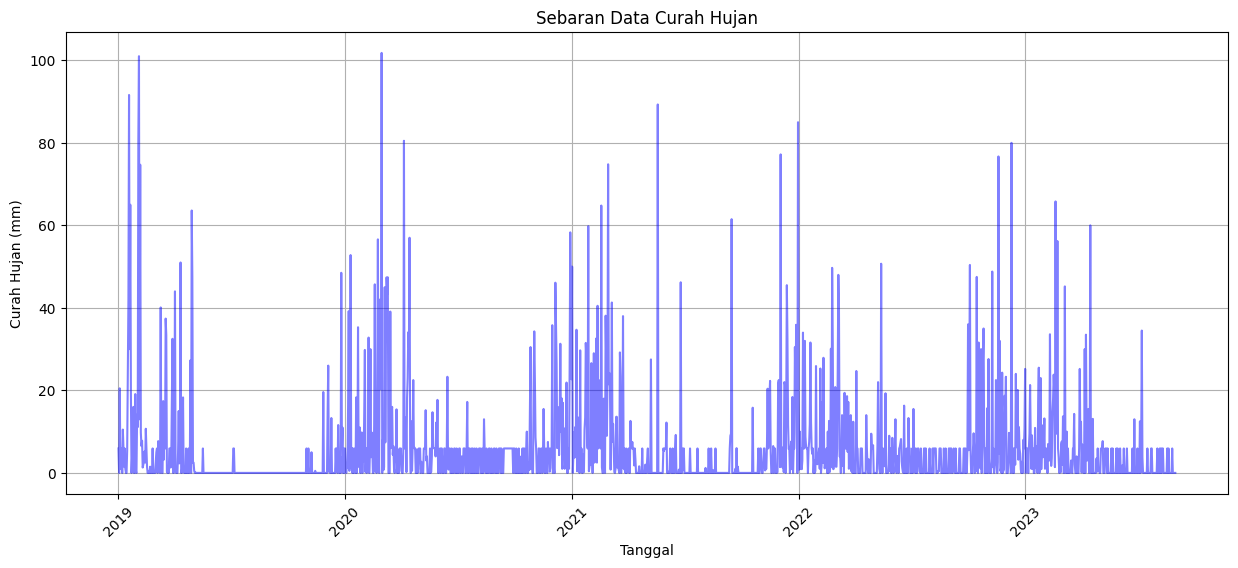

In [13]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df_1['Tanggal'], data_imputasi_df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Membuat DataFrame
data_prediksi_df = pd.DataFrame({'Prediksi_Curah_Hujan': predictions.flatten()})
data_prediksi_df.to_csv('data_prediksi.csv', index=True)
data_prediksi_df

,Prediksi_Curah_Hujan
0,5.607502
1,4.915289
2,4.238640
3,3.698200
4,3.722637
...,...
506,3.047980
507,3.141821
508,3.095442
509,2.969342


In [ ]:
# Membuat DataFrame
data_df = pd.DataFrame({
    'Tanggal': df_1['Tanggal'][1193: ].values,
    'Curah_Hujan': df_2['RR'][1193: ].values,
    'Prediksi_Curah_Hujan': predictions.flatten()  # Pastikan hasil prediksi memiliki dimensi satu
})
data_df.to_csv('dataset&prediksi.csv', index=True)
data_df

,Tanggal,Curah_Hujan,Prediksi_Curah_Hujan
0,2022-04-08,0.000000,5.607502
1,2022-04-09,0.000000,4.915289
2,2022-04-10,0.000000,4.238640
3,2022-04-11,5.923072,3.698200
4,2022-04-12,5.923072,3.722637
...,...,...,...
506,2023-08-27,0.000000,3.047980
507,2023-08-28,0.000000,3.141821
508,2023-08-29,0.000000,3.095442
509,2023-08-30,0.000000,2.969342


In [14]:
n = 1  # Example: Predict the next 10 time steps
future_predictions = []
x_last_window = x_test[-25]  # Menggunakan bagian terakhir dari data testing sebagai x_last_window
last_window = x_last_window.reshape((1, x_last_window.shape[0], x_last_window.shape[1]))

for _ in range(n):
    # Predict the next time step
    prediction = model.predict(last_window)

    # Append the prediction to the list of future predictions
    future_predictions.append(prediction[0])

    # Update the last window by removing the first element and appending the prediction
    last_window = np.append(last_window[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert the list of future predictions to a numpy array
future_predictions = np.array(future_predictions)
print('future_predictions : ', future_predictions)

# Inverse transform predictions to get the original scale
future_predictions_denormalisasi = scaler.inverse_transform(future_predictions)
print('future_predictions_denormalisasi : ', future_predictions_denormalisasi)

1/1 [==============================] - 0s 67ms/step
future_predictions :  [[0.03016319]]
future_predictions_denormalisasi :  [[3.0706131]]


<ipython-input-29-65b5182c9f66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


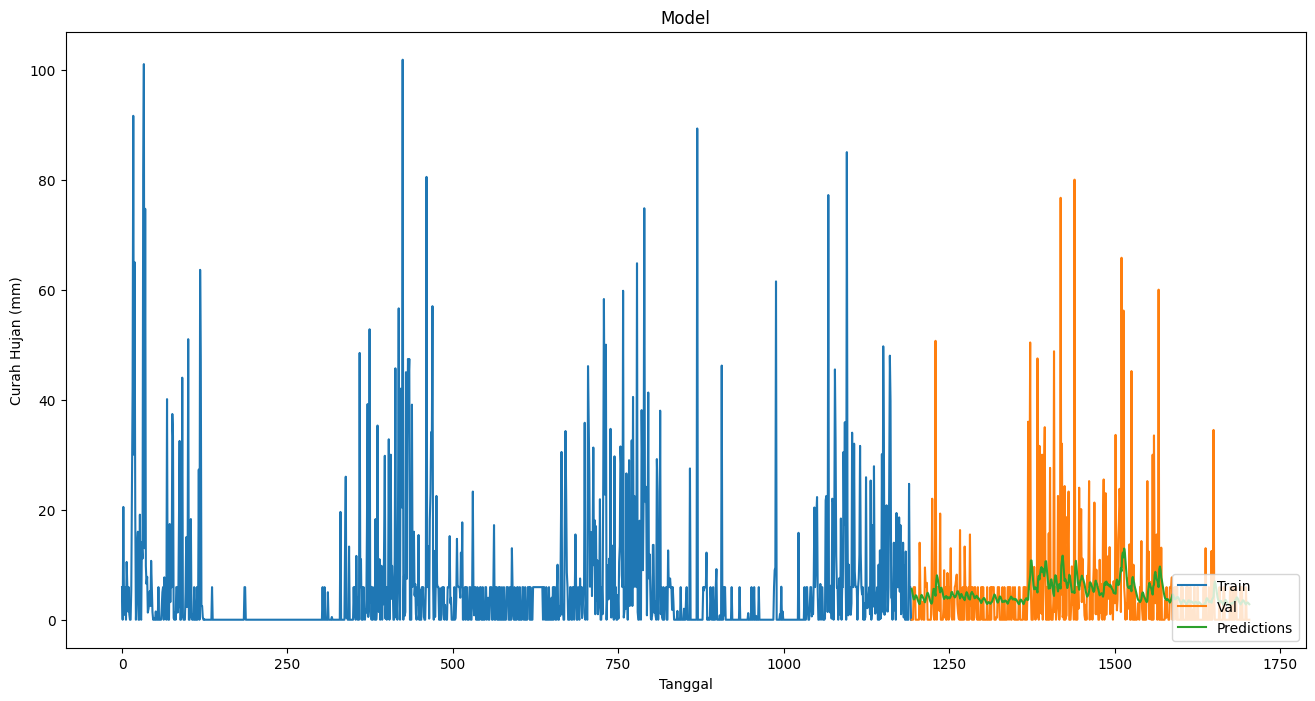

In [ ]:
data = df_2.filter(['RR'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.plot(train)
plt.plot(validation[['RR', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

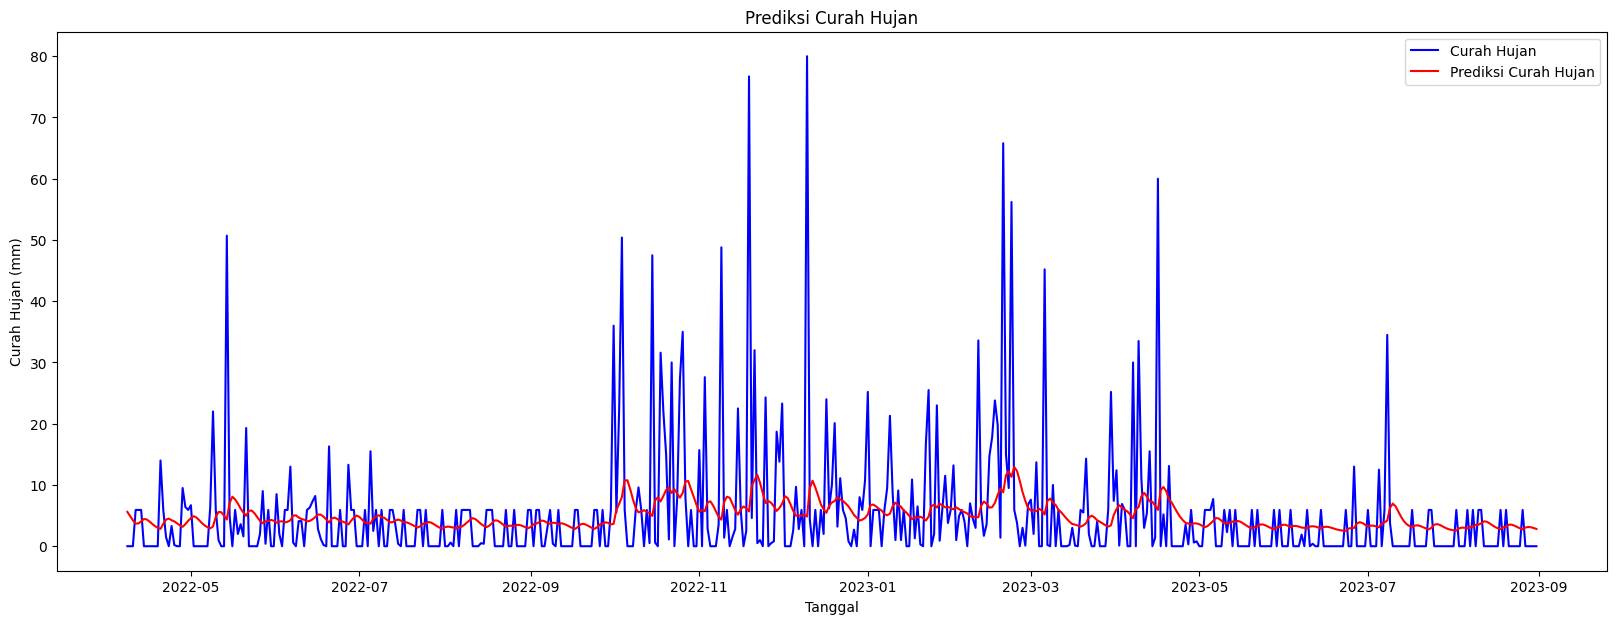

In [ ]:
#Memvisualisasikan hasil prediksi
plt.figure(figsize=(20,7))
plt.plot(df_1['Tanggal'].values[1193:], values[1193:], color = 'blue', label = 'Curah Hujan')
plt.plot(df_1['Tanggal'][-predictions.shape[0]:].values, predictions, color = 'red', label = 'Prediksi Curah Hujan')
plt.title('Prediksi Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save("model_lstm_knn_s1.hdf5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
